In [65]:
import yfinance as yf
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import talib
equity = yf.Ticker("^BSESN")
data = equity.history(start='2022-09-02', end='2022-09-03', interval='1m')
df=data['Close']

In [66]:
def RSI(data, window=14, adjust=False):
    delta = data['Close'].diff(1).dropna()
    loss = delta.copy()
    gains = delta.copy()

    gains[gains < 0] = 0
    loss[loss > 0] = 0

    gain_ewm = gains.ewm(com=window - 1, adjust=adjust).mean()
    loss_ewm = abs(loss.ewm(com=window - 1, adjust=adjust).mean())

    RS = gain_ewm / loss_ewm
    RSI = 100 - 100 / (1 + RS)

    return RSI

In [67]:
reversed_df = data.iloc[::-1]
data["RSI"] = talib.RSI(reversed_df["Close"], 14)

<AxesSubplot:xlabel='Datetime'>

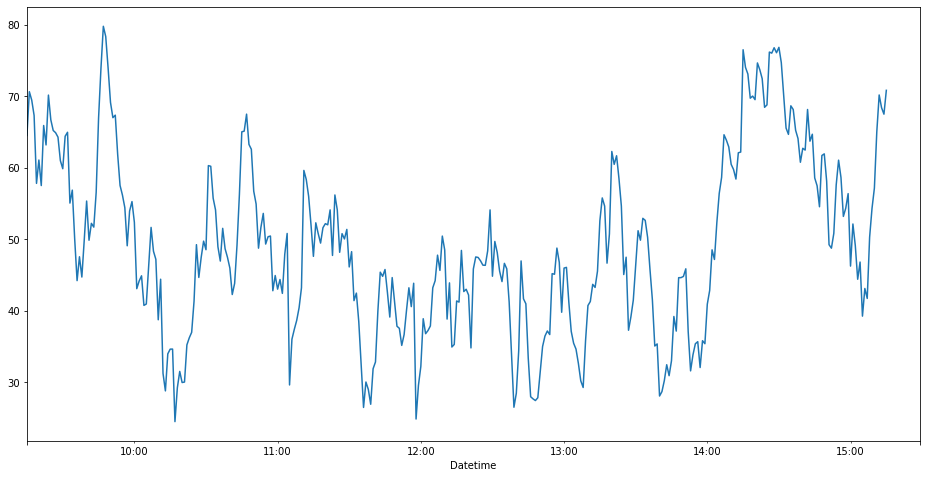

In [68]:
RSI=data['RSI']
RSI.plot(figsize=(16, 8))

In [79]:
#Simple moving average
sma = df.rolling(window=100).mean()
sma_rsi=RSI.rolling(window=100).mean()

In [80]:

# updating our dataFrame to have only
# one column 'Close' as rest all columns
# are of no use for us at the moment
# using .to_frame() to convert pandas
# series into dataframe.
df2=data
df2 = df2['Close'].to_frame()
 
# calculating exponential moving average
# using .ewm(span).mean() , with window size = 30
df2['EWMA200'] = df2['Close'].ewm(span=200).mean()
 
# printing Dataframe
df2['EWMA200']

Datetime
2022-09-02 09:15:00+05:30    59029.339844
2022-09-02 09:16:00+05:30    59050.625430
2022-09-02 09:17:00+05:30    59051.474856
2022-09-02 09:18:00+05:30    59043.591802
2022-09-02 09:19:00+05:30    59015.859042
                                 ...     
2022-09-02 15:25:00+05:30    58877.677128
2022-09-02 15:26:00+05:30    58876.653355
2022-09-02 15:27:00+05:30    58875.690131
2022-09-02 15:28:00+05:30    58874.429756
2022-09-02 15:29:00+05:30    58873.344453
Name: EWMA200, Length: 375, dtype: float64

<AxesSubplot:xlabel='Datetime'>

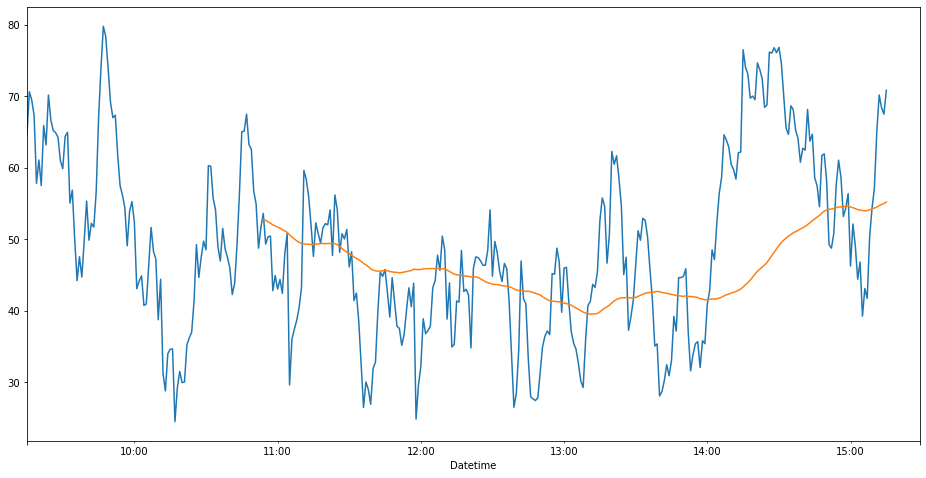

In [81]:
RSI.plot(figsize=(16, 8))
sma_rsi.plot()

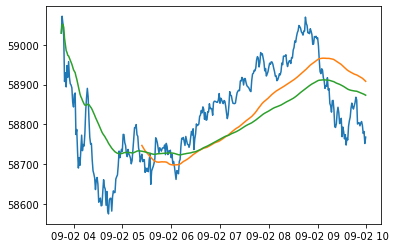

In [82]:
plt.plot(df, label='Close Price')
plt.plot(sma, label='SMA')
plt.plot(df2['EWMA200'], label='EMA')
plt.show()

In [83]:
rstd = df.rolling(window=20).std()

In [86]:
upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd

<AxesSubplot:xlabel='Datetime'>

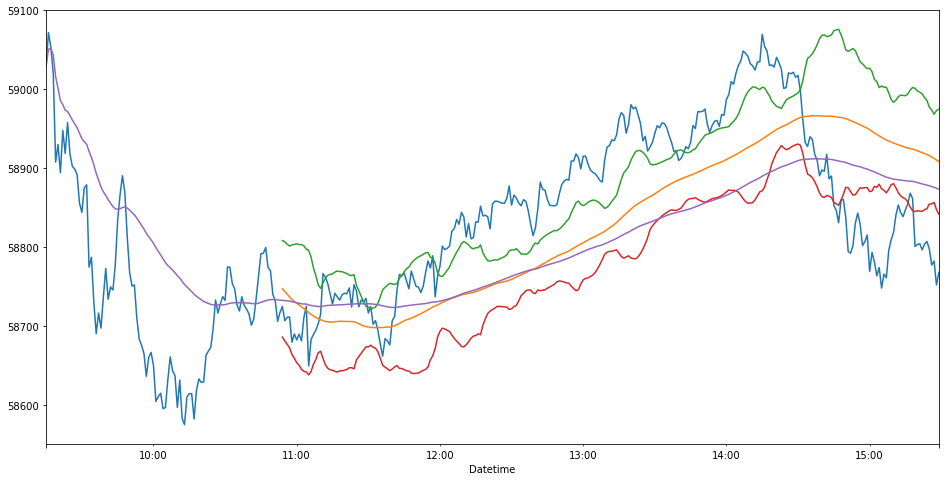

In [87]:
df.plot(figsize=(16, 8))
sma.plot()
upper_band.plot()
lower_band.plot()
df2['EWMA200'].plot()

<AxesSubplot:xlabel='Datetime'>

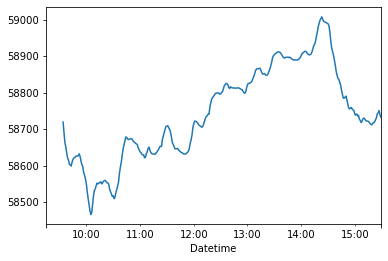

In [76]:
lower_band.plot()

In [78]:
def backtest_supertrend(df, investment):
    close=df
    stop_loss=-50
    bought=0
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    p=0
    l=0
    
    q=0
    f=0
    #trades done
    tr=0
    avg_win=0
    avg_loss=0
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and (df[i]<lower_band[i]) and (df2['EWMA200'][i]>df2['EWMA200'][i-1]):
            tr=tr+1
            #share = math.floor(equity / close[i] / 100) * 100
            share=1
            bought=close[i]
            #print(bought)
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
            q=q+round(close[i],2)
        # if in position & price is not on uptrend -> sell
        if in_position and ((df[i]>=upper_band[i])):
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            share=0
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
            f=f+round(close[i],2)
            #print(q)
            #print(f)
            if(close[i]>bought):
                p=p+1
                avg_win=avg_win+close[i]-bought
            else:
                l=l+1
                avg_loss=avg_loss+bought-close[i]
        if in_position and (df[i]-bought<=stop_loss):
            signal=bought+stop_loss
            equity += share * signal - commission
            exit.append((i, signal))
            in_position = False
            share=0
            print(f'Sell at {round(signal,2)} on {df.index[i].strftime("%Y/%m/%d")}')
            #print(signal)
            f=f+round(signal,2)
            #print(q)
            #print(f)
            if(signal>bought):
                p=p+1
                avg_win=avg_win+signal-bought
            else:
                l=l+1
                avg_loss=avg_loss+bought-signal
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
        f=f+close[i]
        if(close[i]>bought):
            p=p+1
        else:
            l=l+1
        
    avg_win=avg_win/tr
    avg_loss=avg_loss/tr
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing 100k is ${round(earning,2)} (ROI = {roi}%)')
    print(f'p:l(number)={p}:{l}')
    if(p+l==0):
        per=0
    else:
        per=p/(l+p)*100
    print(f'success % ={per}%')
    print(q)
    print(f)
    print(f'Average win ={avg_win}')
    print(f'Average loss ={avg_loss}')
    return entry, exit, equity
entry, exit, roi = backtest_supertrend(df, 100000)

Buy 1 shares at 59001.02 on 2022/09/02
Sell at 58951.02 on 2022/09/02
Earning from investing 100k is $-55.0 (ROI = -0.06%)
p:l(number)=0:1
success % =0.0%
59001.02
58951.02
Average win =0.0
Average loss =50.0
